In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
from torch import nn
import torchvision
from torchvision import transforms
from dataset import MultiLabelDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from utils import train_transform, evaluate_transform
from sklearn.metrics import recall_score, precision_score, f1_score, auc

2091lines [00:00, 190608.75lines/s]


In [2]:
CONDITIONS = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
              'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
              'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
              'Support Devices', 'No Finding']

torch.Size([1, 10, 3, 224, 224])


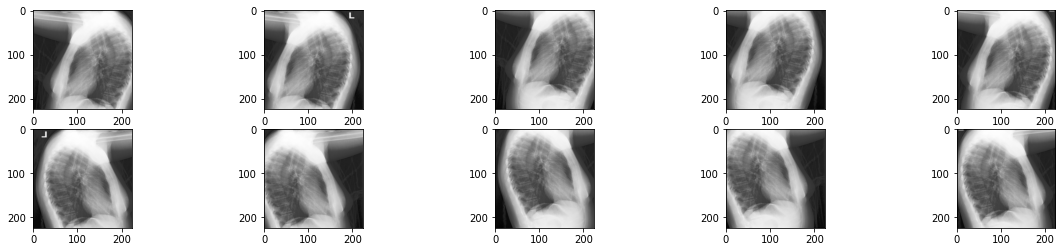

In [3]:
# Find mean and std for normalization
def find_mean_std_image():
    train_loader = DataLoader(
        MultiLabelDataset('train'),
        batch_size=64,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    
    tensors = []
    for i, (imgs, labels) in enumerate(tqdm(train_loader)):
        tensors.append(imgs)
        if i > len(train_loader) // 2: # Sample just first half
            break

    print(len(tensors))
    mean = torch.stack(tensors).mean(axis=[0, 1, 2, 3])
    std = torch.stack(tensors).std(axis=[0, 1, 2, 3])
    return mean, std

def to_tensors(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])

def plot_sample_images():
    test_dataset = MultiLabelDataset(
        'test',
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.TenCrop(224),
            transforms.Lambda(to_tensors),
            # transforms.Lambda(normalize_lambda)
    ]))

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    inp, target = next(iter(test_loader))
    print(inp.shape)
    
    plt.figure(figsize=(20, 4))
    for i in range(10):
        image = inp[0][i].permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(image)
    plt.show()

# find_mean_std_image()
plot_sample_images()


In [4]:
class Chexnet(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, input_size=(256, 256), pretrained=True):
        super(Chexnet, self).__init__()

        encoded_image_size = input_size[0] // 32
        self.linear_input_size = 1024 * encoded_image_size ** 2
        
        # Load densenet pretrained weight into this
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        
        # Original chexnet classifier
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 14),
            nn.Sigmoid()
        )

        # Pretrained weights?
        if pretrained:
            print(f"loading pretrained weights..")
            chexnet_checkpoint_path = 'weights/chexnet.pth.tar'
            checkpoint = torch.load(chexnet_checkpoint_path)
            self.load_state_dict(checkpoint['state_dict'], strict=False)

        # Create the true densenet we're going to use
        modules = list(self.densenet121.children())[:-1]
        self.true_densenet = nn.Sequential(*modules)

        # New classifier head
        self.fc = nn.Linear(self.linear_input_size, len(CONDITIONS))

        self = self.cuda()

    def forward(self, x):
        encoded_images = self.true_densenet(x)
        flattened = encoded_images.reshape(-1, self.linear_input_size)
        probs = torch.sigmoid(self.fc(flattened))
        return encoded_images, probs

In [5]:
def lr_finder(encoder, imgs, labels, sweep_range):
    losses = []
    for lr in tqdm(sweep_range):
        # Init
        encoder = encoder.cuda()

        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(encoder.parameters(), lr)

        # Train 1 minibatch
        _, probs = encoder(imgs)
        loss = loss_fn(probs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # After
        _, probs = encoder(imgs)
        loss_after = loss_fn(probs, labels)
        losses.append(loss_after.detach().item())

        # t = torch.cuda.get_device_properties(0).total_memory
        # r = torch.cuda.memory_reserved(0)
        # a = torch.cuda.memory_allocated(0)
        # f = r-a  # free inside reserved
        # print(f"total: {t}\treserved: {r}\tallocated: {a}\tfree: {f}")

    
    return losses

def find_lr(encoder_cls, attempts=1):
    train_loader = DataLoader(
            MultiLabelDataset('train', transform=train_transform),
            batch_size=16,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )
    imgs, labels = next(iter(train_loader))
    sweep_range = np.hstack([[*range(1, 10, 2)][::-1] / 10 ** e for e in np.arange(4, 8, 1)])[::-1]

    for i in range(attempts):
        losses = lr_finder(encoder_cls, imgs.cuda(), labels.cuda(), sweep_range)
        plt.xscale('log')
        plt.plot(sweep_range, losses)
        plt.show()

    idx = np.argmin(losses)
    best_lr = sweep_range[idx]
    return best_lr

# best_lr = find_lr(Chexnet(pretrained=False), attempts=1)
# print(f"best_lr={best_lr}")

In [6]:
def save_checkpoint(epoch, encoder, optimizer, scheduler, train_loss, val_loss):
    cur_time = str(datetime.now())
    state = {'epoch': epoch,
             'encoder': encoder,
             'optimizer': optimizer,
             'scheduler': scheduler,
             'time_saved': cur_time,
             'train_loss': train_loss,
             'val_loss': val_loss,
    }

    cur_time = cur_time.replace(' ', '_').replace(':', '-')
    filename = f'weights/pretrained_encoder/pretrained_enc_epoch_{epoch+1}_' + cur_time + '.pth.tar'
    torch.save(state, filename)

def pretrain_encoder(encoder, train_loader, loss_fn, optimizer, gradient_accum_iter, epoch):
    encoder.train()
    losses = []

    for i, (imgs, labels) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        imgs = imgs.cuda()
        labels = labels.cuda()

        _, probs = encoder(imgs)
        loss = loss_fn(probs, labels)
        losses.append(loss.detach())
        loss.backward()
        if ((i + 1) % gradient_accum_iter) == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    return torch.stack(losses).mean()

def validate_pretrained_encoder(encoder, val_loader, loss_fn):
    encoder.eval()
    losses = []
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(val_loader)):
            imgs = imgs.cuda()
            labels = labels.cuda()

            _, probs = encoder(imgs)
            loss = loss_fn(probs, labels)
            losses.append(loss.detach())
            

    return torch.stack(losses).mean()

In [7]:
# checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_2022-02-26_16-38-13.950274.pth.tar' # Pretrained Chexnet epoch 9
# checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-01_21-55-18.022861.pth.tar' # Pretrained Chexnet 14 labels epoch 5
# checkpoint_path = None
# checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-08_15-43-47.540586.pth.tar' # Full data
checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-09_05-30-31.063956.pth.tar'
epochs = 5
batch_size = 16
gradient_accum_iter = 8
if checkpoint_path != None:
    checkpoint = torch.load(checkpoint_path)
    start_epoch = checkpoint['epoch'] + 1
    encoder = checkpoint['encoder']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    print(f"start from epoch: {start_epoch} val_loss: {checkpoint['val_loss']}")
else:
    start_epoch = 0
    encoder = Chexnet(pretrained=False).cuda()
    optimizer = torch.optim.Adam(encoder.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=0.2, 
        patience=1, 
        min_lr=1e-6
    )

loss_fn = nn.BCELoss().cuda()

start from epoch: 10 val_loss: 0.2689065635204315


In [8]:
train_loader = DataLoader(
    MultiLabelDataset('train', transform=train_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    MultiLabelDataset('val', transform=evaluate_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    MultiLabelDataset('test', transform=evaluate_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [9]:
lrs = []
train_plot = []
val_plot = []

In [10]:
def train():
    print(f"start training from epoch {start_epoch}")
    for epoch in range(start_epoch, start_epoch + epochs):
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        print(f"Training epoch {epoch+1} with lr = {current_lr}...")
        train_loss = pretrain_encoder(encoder, train_loader, loss_fn, optimizer, gradient_accum_iter, epoch)
        print(f"Validating...")
        val_loss = validate_pretrained_encoder(encoder, val_loader, loss_fn)
        print(f"train_loss: {train_loss}, val_loss: {val_loss}")
        train_plot.append(train_loss)
        val_plot.append(val_loss)
        scheduler.step(val_loss)
        save_checkpoint(epoch, encoder, optimizer, scheduler, train_loss, val_loss)

In [11]:
train()

start training from epoch 0
Training epoch 1 with lr = 5e-05...


100%|██████████| 12824/12824 [1:23:39<00:00,  2.55it/s]


Validating...


100%|██████████| 1710/1710 [04:26<00:00,  6.42it/s]


train_loss: 0.3585147261619568, val_loss: 0.32150548696517944
Training epoch 2 with lr = 5e-05...


  4%|▍         | 528/12824 [04:00<1:33:10,  2.20it/s]


KeyboardInterrupt: 

In [23]:
train()

start training from epoch 0
Training epoch 1 with lr = 3e-05...


100%|██████████| 321/321 [03:46<00:00,  1.42it/s]


Validating...


100%|██████████| 43/43 [00:11<00:00,  3.63it/s]


train_loss: 0.5253541469573975, val_loss: 0.43702489137649536
Training epoch 2 with lr = 3e-05...


100%|██████████| 321/321 [03:36<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.95it/s]


train_loss: 0.42558833956718445, val_loss: 0.4009576439857483
Training epoch 3 with lr = 3e-05...


100%|██████████| 321/321 [03:34<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


train_loss: 0.39416739344596863, val_loss: 0.377093642950058
Training epoch 4 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


train_loss: 0.37309420108795166, val_loss: 0.3667204678058624
Training epoch 5 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


train_loss: 0.3607887923717499, val_loss: 0.3646099269390106
Training epoch 6 with lr = 3e-05...


100%|██████████| 321/321 [03:41<00:00,  1.45it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.92it/s]


train_loss: 0.3566570580005646, val_loss: 0.3583161532878876
Training epoch 7 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.91it/s]


train_loss: 0.3438238501548767, val_loss: 0.35245031118392944
Training epoch 8 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:11<00:00,  3.89it/s]


train_loss: 0.33446624875068665, val_loss: 0.3482198119163513
Training epoch 9 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.91it/s]


train_loss: 0.32964634895324707, val_loss: 0.3464947044849396
Training epoch 10 with lr = 3e-05...


100%|██████████| 321/321 [03:35<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.91it/s]


train_loss: 0.3249985873699188, val_loss: 0.3472270369529724
Training epoch 11 with lr = 3e-05...


100%|██████████| 321/321 [03:34<00:00,  1.49it/s]


Validating...


100%|██████████| 43/43 [00:11<00:00,  3.87it/s]


train_loss: 0.32255980372428894, val_loss: 0.34604331851005554
Training epoch 12 with lr = 3e-05...


100%|██████████| 321/321 [03:33<00:00,  1.50it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


train_loss: 0.31451189517974854, val_loss: 0.33985254168510437
Training epoch 13 with lr = 3e-05...


100%|██████████| 321/321 [03:33<00:00,  1.50it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


train_loss: 0.3089786171913147, val_loss: 0.339821457862854
Training epoch 14 with lr = 3e-05...


100%|██████████| 321/321 [03:33<00:00,  1.50it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.92it/s]


train_loss: 0.3095320165157318, val_loss: 0.3392534852027893
Training epoch 15 with lr = 3e-05...


100%|██████████| 321/321 [03:33<00:00,  1.51it/s]


Validating...


100%|██████████| 43/43 [00:10<00:00,  3.92it/s]


train_loss: 0.3086918592453003, val_loss: 0.3381898105144501


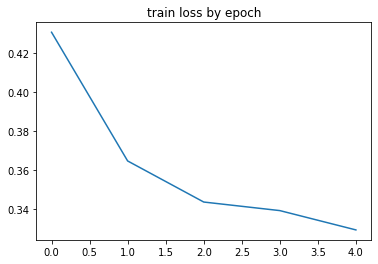

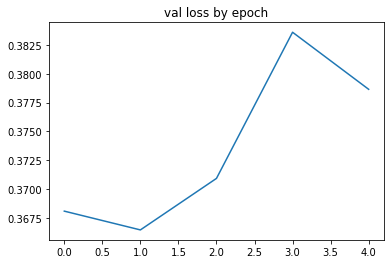

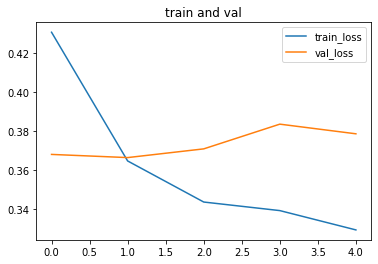

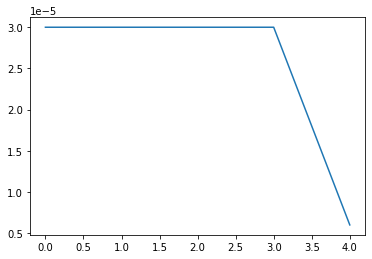

In [38]:
plt.title('train loss by epoch')
plt.plot(train_plot)
plt.show()
plt.title('val loss by epoch')
plt.plot(val_plot)
plt.show()
plt.title('train and val')
plt.plot(train_plot, label='train_loss')
plt.plot(val_plot, label='val_loss')
plt.legend()
plt.show()

plt.plot(lrs)
plt.show()

In [10]:
def predict_eval(encoder, data_loader, loss_fn):
    encoder.eval()
    losses = []
    results = []
    true = []
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(data_loader)):
            imgs = imgs.cuda()
            labels = labels.cuda()

            _, probs = encoder(imgs)
            loss = loss_fn(probs, labels)
            losses.append(loss)
            true.append(labels)
            results.append(probs)

    val_loss = torch.stack(losses).mean()
    print(f"val_loss: {val_loss}")

    val_preds = torch.cat(results).reshape(-1, len(CONDITIONS))
    ground_truth = torch.cat(true).reshape(-1, len(CONDITIONS))
    return val_preds, ground_truth

def get_tpr_fpr(pred, true, threshold):
    p = pred.clone()
    t = true.clone()
    p = (p > threshold).int().cpu().numpy()
    t = t.int().cpu().numpy()

    tp = np.count_nonzero(np.logical_and(p == 1, t == 1), axis=0)
    tn = np.count_nonzero(np.logical_and(p == 0, t == 0), axis=0)
    fp = np.count_nonzero(np.logical_and(p == 1, t == 0), axis=0)
    fn = np.count_nonzero(np.logical_and(p == 0, t == 1), axis=0)
    
    tpr = np.zeros(len(CONDITIONS))
    fpr = np.zeros(len(CONDITIONS))

    for i in range(len(CONDITIONS)):
        if tp[i] + fn[i] == 0:
            tpr[i] = 0.0
        else:
            tpr[i] = tp[i] / (tp[i] + fn[i])
        
        if tn[i] + fp[i] == 0:
            fpr[i] = 0.0
        else:
            fpr[i] = fp[i] / (tn[i] + fp[i])

    return tpr, fpr

def roc_coords(pred, true):
    threshold_sweep = np.arange(0.000, 1.001, 0.001)
    tprs = []
    fprs = []
    
    # -1 as default value
    best_threshold = -np.ones(len(CONDITIONS))
    best_tpr = -np.ones(len(CONDITIONS))
    best_fpr = -np.ones(len(CONDITIONS))
    
    for t in threshold_sweep:
        tpr, fpr = get_tpr_fpr(pred, true, t)
        tprs.append(tpr)
        fprs.append(fpr)
        
        for i in range(len(CONDITIONS)):
            if 1-tpr[i] - fpr[i] > 0 and best_threshold[i] == -1: # -1 is default value
                best_tpr[i] = tpr[i]
                best_fpr[i] = fpr[i]
                best_threshold[i] = t
    
    tprs = np.vstack(tprs).T # (len(CONDITIONS), sample_size)
    fprs = np.vstack(fprs).T # (len(CONDITIONS), sample_size)

    return tprs, fprs, best_tpr, best_fpr, best_threshold

def plot_roc(val_preds, ground_truth):
    tprs, fprs, best_tpr, best_fpr, best_threshold = roc_coords(val_preds, ground_truth)
    aucs = np.zeros(len(CONDITIONS))
    plt.figure(figsize=(28, 8))
    
    for i in range(len(CONDITIONS)):
        x = np.arange(0, 1, 1/len(tprs[i]))
        y = np.arange(1, 0, -1/len(tprs[i]))
        area = auc(fprs[i], tprs[i])
        aucs[i] = area
        title = \
            f'{CONDITIONS[i]}\n' + \
            f'EER={best_tpr[i]:4f}\n' + \
            f'Best threshold = {best_threshold[i]:4f}\n' + \
            f'AUROC={area:.4f}'
        
        plt.subplot(2, 7, i+1)
        plt.title(title)
        plt.plot(x, y, 'r--')
        plt.plot(fprs[i], tprs[i])
        plt.plot(best_fpr[i], best_tpr[i], 'go')
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame.from_dict({
        'Diagnosis': CONDITIONS,
        'EER': best_tpr,
        'Best Threshold': best_threshold,
        'AUROC': aucs,
    }).set_index('Diagnosis')

    return df

def plot_roc_multiple(val_preds, ground_truth, label):
    tprs, fprs, best_tpr, best_fpr, best_threshold = roc_coords(val_preds, ground_truth)
    aucs = np.zeros(len(CONDITIONS))
    plt.figure(figsize=(28, 8))
    
    for i in range(len(CONDITIONS)):
        x = np.arange(0, 1, 1/len(tprs[i]))
        y = np.arange(1, 0, -1/len(tprs[i]))
        area = auc(fprs[i], tprs[i])
        aucs[i] = area
        title = \
            f'{CONDITIONS[i]}\n' + \
            f'EER={best_tpr[i]:4f}\n' + \
            f'Best threshold = {best_threshold[i]:4f}\n' + \
            f'AUROC={area:.4f}'
        
        plt.subplot(2, 7, i+1)
        plt.title(title)
        plt.plot(x, y, 'r--')
        plt.plot(fprs[i], tprs[i], label=label)
        plt.plot(best_fpr[i], best_tpr[i], 'go')

    df = pd.DataFrame.from_dict({
        'Diagnosis': CONDITIONS,
        'EER': best_tpr,
        'Best Threshold': best_threshold,
        'AUROC': aucs,
    }).set_index('Diagnosis')

    return df

def evaluate_models(model_paths):
    tprs_list = []
    fprs_list = []
    best_tpr_list = []
    best_fpr_list = []
    best_threshold_list = []
    aucs = -np.ones((len(model_paths), len(CONDITIONS)))
    for model_path in model_paths:
        checkpoint = torch.load(model_path)
        print(f"Evaluating {model_path} ... (epoch {checkpoint['epoch'] + 1})")
        encoder = checkpoint['encoder']
        val_preds, val_ground_truth = predict_eval(encoder, val_loader, loss_fn)
        
        tprs, fprs, best_tpr, best_fpr, best_threshold = roc_coords(val_preds, val_ground_truth)
        tprs_list.append(tprs)
        fprs_list.append(fprs)
        best_tpr_list.append(best_tpr)
        best_fpr_list.append(best_fpr)
        best_threshold_list.append(best_threshold)
    
    plt.figure(figsize=(42, 12))
    for i in range(len(CONDITIONS)):
        title = CONDITIONS[i]
        plt.subplot(2, 7, i+1)
        plt.title(title)
        x = np.arange(0, 1, 1/len(tprs_list[0][i]))
        y = np.arange(0, 1, 1/len(tprs_list[0][i]))
        y_rev = np.arange(1, 0, -1/len(tprs_list[0][i]))
        plt.plot(x, y_rev, 'r--')
        plt.plot(x, y, 'b--')
        for j in range(len(model_paths)):
            area = auc(fprs_list[j][i], tprs_list[j][i])
            aucs[j, i] = area
            plt.plot(fprs_list[j][i], tprs_list[j][i], label=f"model_{j+1}")
            # plt.plot(best_fpr_list[j][i], best_tpr_list[j][i], 'go')

    plt.legend()
    plt.tight_layout()
    plt.show()

    d = {
        'Diagnosis': CONDITIONS,
    }

    for j in range(len(model_paths)):
        d[f'model_{j+1}_AUROC'] = aucs[j]

    df = pd.DataFrame.from_dict(d).set_index('Diagnosis')
    df.loc['Mean'] = df.mean()
    return df

Evaluating weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-07_17-32-49.918963.pth.tar ... (epoch 10)


100%|██████████| 1710/1710 [04:41<00:00,  6.07it/s]


val_loss: 0.3557756245136261
Evaluating weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-08_15-43-47.540586.pth.tar ... (epoch 5)


100%|██████████| 1710/1710 [04:14<00:00,  6.71it/s]


val_loss: 0.28202417492866516
Evaluating weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-09_05-30-31.063956.pth.tar ... (epoch 10)


100%|██████████| 1710/1710 [04:28<00:00,  6.37it/s]


val_loss: 0.2689065635204315


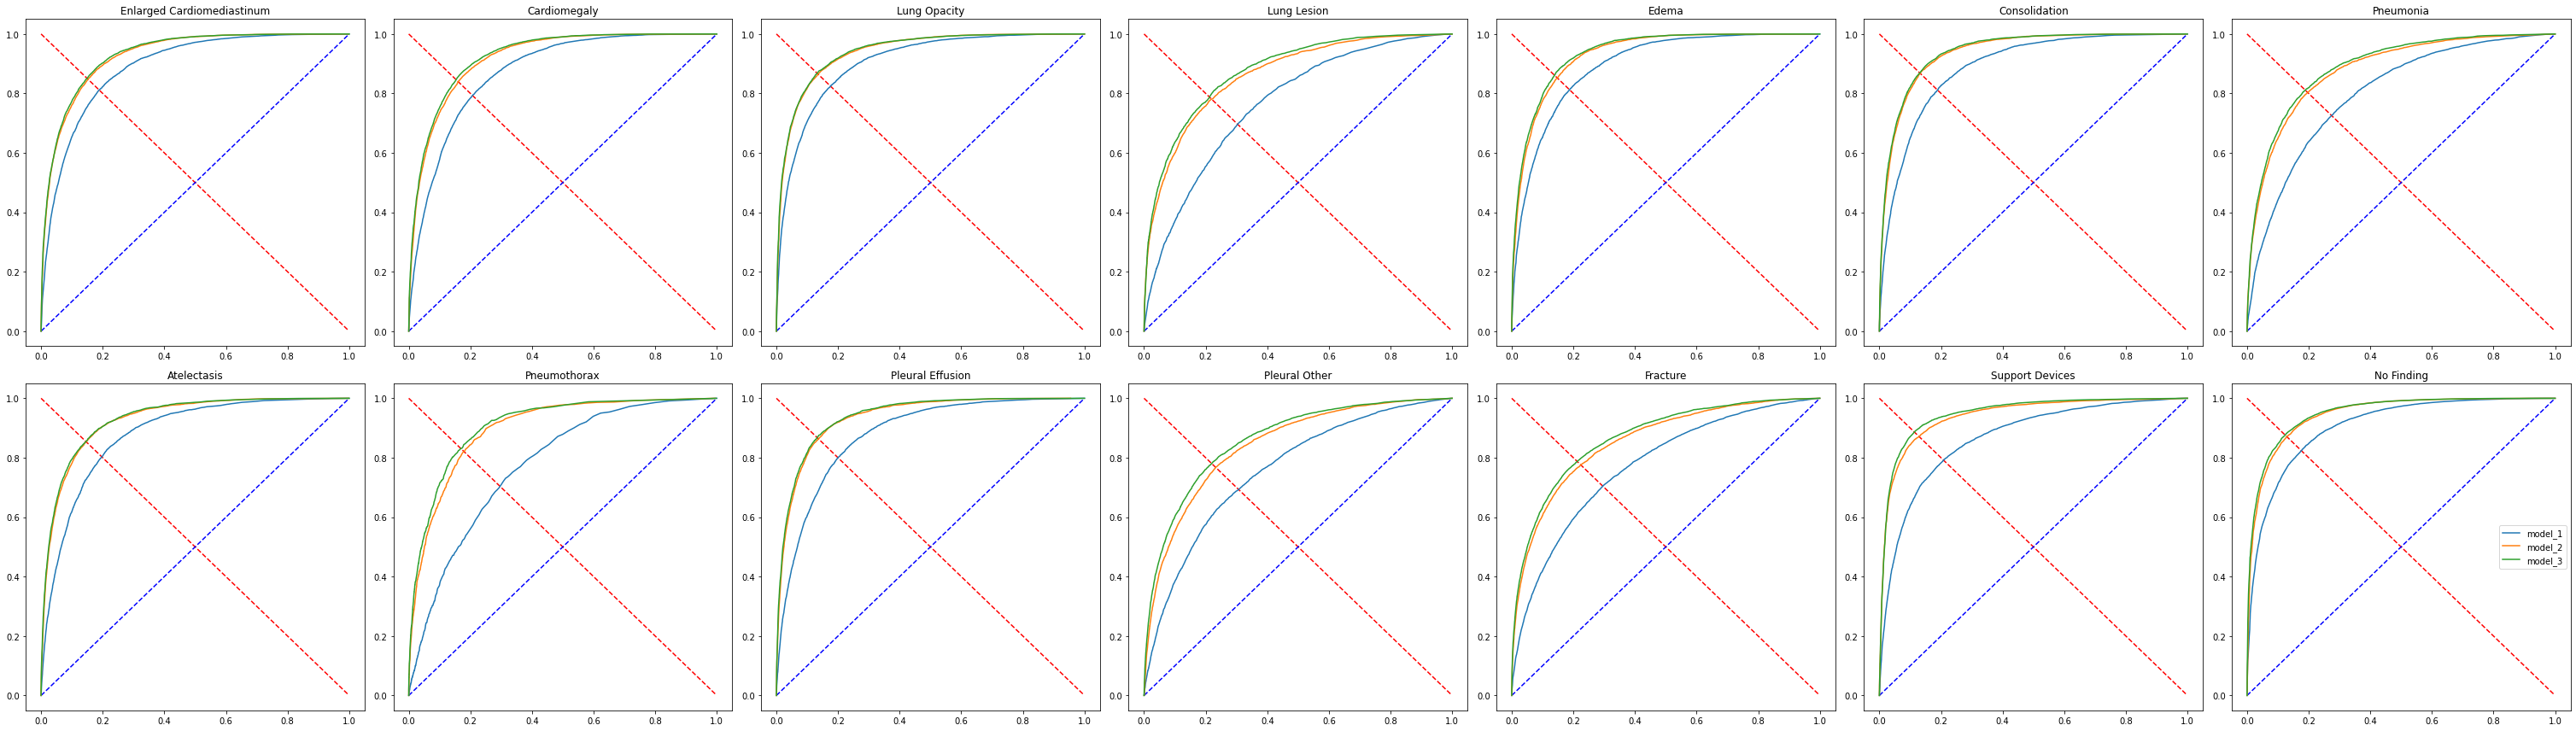

In [12]:
model_paths = [
    # 'weights/pretrained_encoder/pretrained_enc_epoch_1_2022-03-01_21-25-43.558663.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_2_2022-03-01_21-33-03.324598.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_3_2022-03-01_21-40-23.618929.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_4_2022-03-01_21-47-49.833802.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-01_21-55-18.022861.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-01_23-09-33.796416.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_1_2022-03-07_15-05-00.074771.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-07_15-26-56.402211.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-07_16-26-30.081634.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-07_16-45-39.632080.pth.tar',
    'weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-07_17-32-49.918963.pth.tar', # Partial data 14
    # 'weights/pretrained_encoder/pretrained_enc_epoch_15_2022-03-07_17-51-34.444548.pth.tar' # Partial data 14
    # 'weights/pretrained_encoder/pretrained_enc_epoch_2_2022-03-08_11-10-45.680034.pth.tar', # Full data
    'weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-08_15-43-47.540586.pth.tar',
    # 'weights/pretrained_encoder/pretrained_enc_epoch_8_2022-03-09_02-35-44.194832.pth.tar',
    'weights/pretrained_encoder/pretrained_enc_epoch_10_2022-03-09_05-30-31.063956.pth.tar',
]

result_df = evaluate_models(model_paths)

In [14]:
result_df

,model_1_AUROC,model_2_AUROC,model_3_AUROC
Diagnosis,,,
Enlarged Cardiomediastinum,0.902422,0.918204,0.925560
Cardiomegaly,0.888351,0.907108,0.919013
Lung Opacity,0.915557,0.902393,0.939023
Lung Lesion,0.792945,0.813670,0.862703
Edema,0.908973,0.921698,0.922453
Consolidation,0.905673,0.913651,0.936763
Pneumonia,0.820518,0.854401,0.880906
Atelectasis,0.892463,0.883182,0.927329
Pneumothorax,0.820873,0.829494,0.892633


100%|██████████| 1710/1710 [08:28<00:00,  3.36it/s]


val_loss: 0.28202417492866516


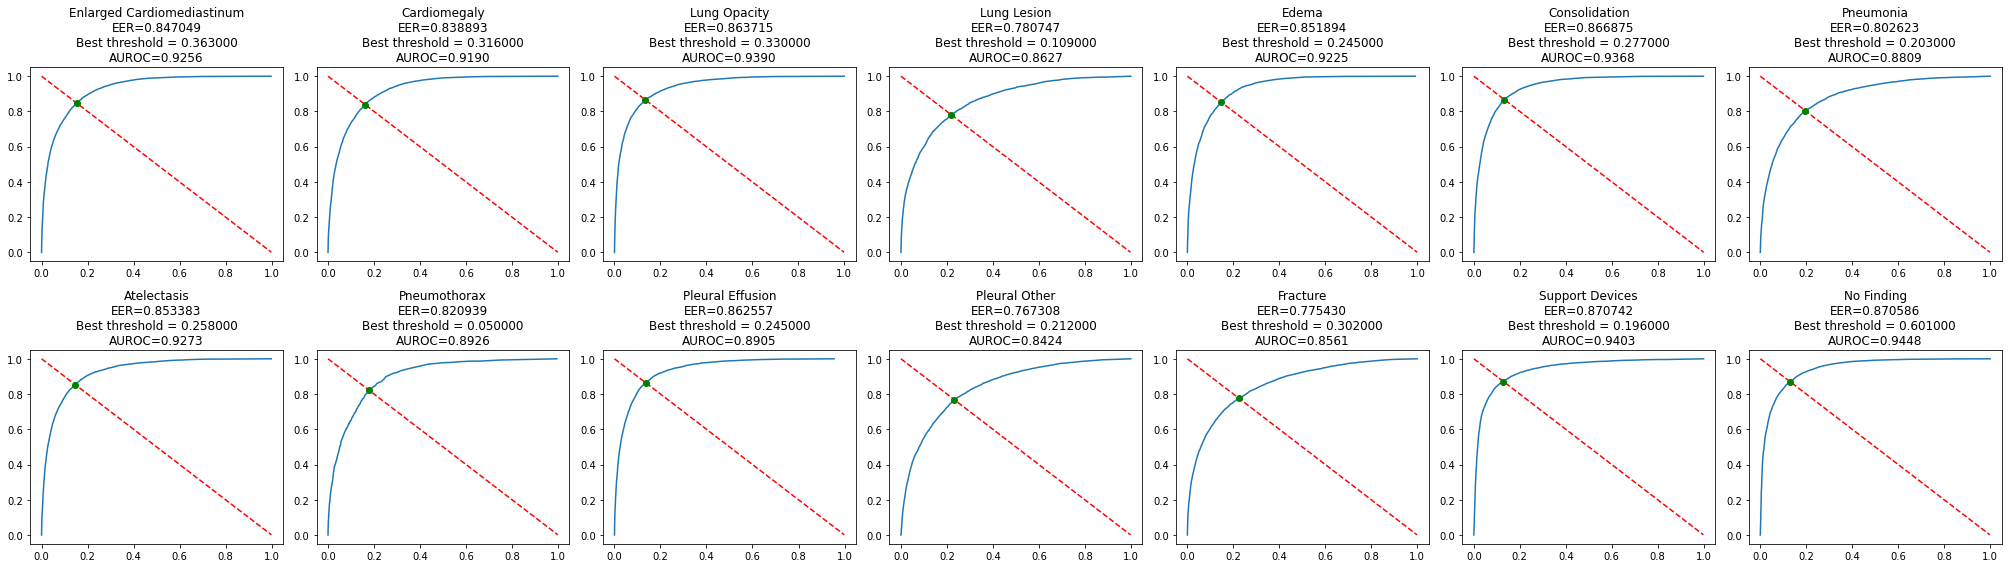

,EER,Best Threshold,AUROC
Diagnosis,,,
Enlarged Cardiomediastinum,0.847049,0.363000,0.925560
Cardiomegaly,0.838893,0.316000,0.919013
Lung Opacity,0.863715,0.330000,0.939023
Lung Lesion,0.780747,0.109000,0.862703
Edema,0.851894,0.245000,0.922453
Consolidation,0.866875,0.277000,0.936763
Pneumonia,0.802623,0.203000,0.880906
Atelectasis,0.853383,0.258000,0.927329
Pneumothorax,0.820939,0.050000,0.892633


In [15]:
def test_model(model_path):
    checkpoint = torch.load(model_path)
    encoder = checkpoint['encoder']
    test_preds, test_ground_truth = predict_eval(encoder, val_loader, loss_fn)
    df = plot_roc(test_preds, test_ground_truth)
    df.loc['Mean'] = df.mean()
    return df

test_model('weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-08_15-43-47.540586.pth.tar')

### ROC Stuff
### Pretrained Chexnet
```
                                 EER  Best Threshold     AUROC  Chexnet
Diagnosis                                                              
Enlarged Cardiomediastinum  0.843373           0.227  0.903488      NaN
Cardiomegaly                0.834286           0.115  0.881514   0.9248
Lung Opacity                0.869249           0.282  0.925403      NaN
Lung Lesion                 0.699248           0.019  0.773435      NaN
Edema                       0.807692           0.070  0.900809   0.8878
Consolidation               0.848708           0.073  0.898465   0.7901
Pneumonia                   0.688372           0.047  0.784017   0.7680
Atelectasis                 0.790614           0.167  0.888520   0.8094
Pneumothorax                0.764706           0.001  0.755832   0.8887
Pleural Effusion            0.885714           0.032  0.889074   0.8638
Pleural Other               0.707547           0.024  0.742141      NaN
Fracture                    0.668657           0.139  0.756783      NaN
Support Devices             0.778116           0.117  0.885187      NaN
```

In [37]:
# Chexnet results from https://arxiv.org/pdf/1711.05225.pdf
val_df['Chexnet'] = [np.nan, 0.9248, np.nan, np.nan, 0.8878, 0.7901, 0.7680, 0.8094, 0.8887, 0.8638, np.nan, np.nan, np.nan]
val_df.round(4)

,EER,Best Threshold,AUROC,Chexnet
Diagnosis,,,,
Enlarged Cardiomediastinum,0.8217,0.321,0.9045,NaN
Cardiomegaly,0.8057,0.180,0.8799,0.9248
Lung Opacity,0.8499,0.344,0.9236,NaN
Lung Lesion,0.6917,0.012,0.7577,NaN
Edema,0.8000,0.045,0.9018,0.8878
Consolidation,0.8266,0.110,0.8963,0.7901
Pneumonia,0.7116,0.031,0.7804,0.7680
Atelectasis,0.7978,0.105,0.8906,0.8094
Pneumothorax,0.7059,0.002,0.7729,0.8887


In [38]:
test_df['Chexnet'] = [np.nan, 0.9248, np.nan, np.nan, 0.8878, 0.7901, 0.7680, 0.8094, 0.8887, 0.8638, np.nan, np.nan, np.nan]
test_df.round(4)

,EER,Best Threshold,AUROC,Chexnet
Diagnosis,,,,
Enlarged Cardiomediastinum,0.8068,0.322,0.8850,NaN
Cardiomegaly,0.7932,0.176,0.8778,0.9248
Lung Opacity,0.8316,0.268,0.9062,NaN
Lung Lesion,0.6435,0.010,0.7187,NaN
Edema,0.7894,0.050,0.8801,0.8878
Consolidation,0.8023,0.078,0.8846,0.7901
Pneumonia,0.7184,0.031,0.7954,0.7680
Atelectasis,0.8030,0.118,0.8772,0.8094
Pneumothorax,0.6761,0.002,0.7623,0.8887


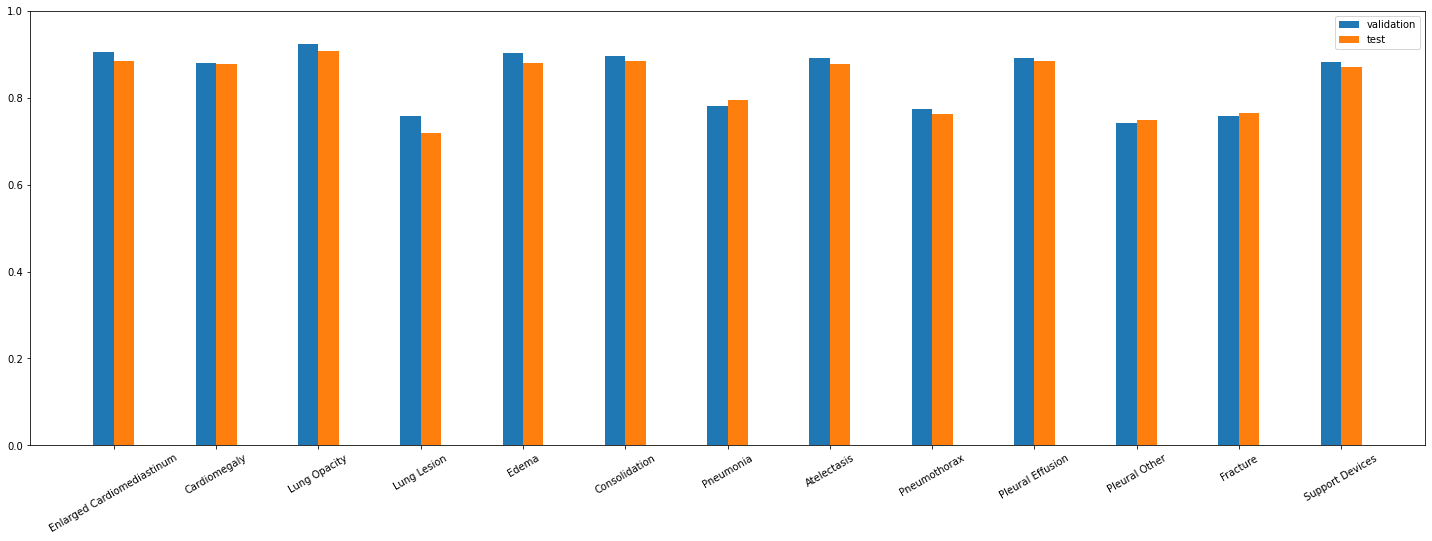

In [61]:
plt.figure(figsize=(25, 8))
plt.xticks(np.arange(len(CONDITIONS)),test_df.index,  rotation=30)
plt.bar(x=np.arange(len(CONDITIONS))-0.1, height=val_df['AUROC'], width=0.2, label='validation')
plt.bar(x=np.arange(len(CONDITIONS))+0.1, height=test_df['AUROC'], width=0.2, label='test')
plt.legend()
plt.ylim(top=1.0)
# plt.bar(x=np.arange(len(CONDITIONS))+0.2, height=val_df['Chexnet'], width=0.2)
plt.show()

## Evaluation Matrix

### Pretrained Chexnet
```
Metrics                       Recall  Precision        F1
Enlarged Cardiomediastinum  0.954217   0.555400  0.702128
Cardiomegaly                0.928571   0.498466  0.648703
Lung Opacity                0.953995   0.579412  0.720952
Lung Lesion                 0.571429   0.249180  0.347032
Edema                       0.884615   0.490405  0.631001
Consolidation               0.896679   0.471845  0.618321
Pneumonia                   0.711628   0.324153  0.445415
Atelectasis                 0.888087   0.447273  0.594921
Pneumothorax                0.352941   0.159292  0.219512
Pleural Effusion            0.881633   0.447205  0.593407
Pleural Other               0.702830   0.280603  0.401077
Fracture                    0.817910   0.357236  0.497278
Support Devices             0.854103   0.503584  0.633596
Macro                       0.799895   0.412619  0.542565
Micro                       0.855961   0.440805  0.581927
```

In [43]:
def evaluation_matrix(pred, true):
    t = true.copy()
    p = pred.copy()

    recall = ['Recall']
    for col in t.columns:
        recall.append(recall_score(t[col], p[col]))

    recall.append(recall_score(t, p, average='macro'))
    recall.append(recall_score(t, p, average='micro'))

    precision = ['Precision']
    for col in t.columns:
        precision.append(precision_score(t[col], p[col]))

    precision.append(precision_score(t, p, average='macro'))
    precision.append(precision_score(t, p, average='micro'))

    f1 = ['F1']
    for col in t.columns:
        f1.append(f1_score(t[col], p[col]))

    f1.append(f1_score(t, p, average='macro'))
    f1.append(f1_score(t, p, average='micro'))

    res = pd.DataFrame([
        recall,
        precision,
        f1
    ], columns=['Metrics'] + list(t.columns) + ['Macro', 'Micro'])
    res = res.set_index(['Metrics'])

    return res.T

best_threshold = 0.034
pred_df = pd.DataFrame((val_preds > best_threshold).int().cpu().numpy(), columns=CONDITIONS)
true_df = pd.DataFrame(ground_truth.int().cpu().numpy(), columns=CONDITIONS)
evaluation_matrix(pred_df, true_df)

Metrics,Recall,Precision,F1
Enlarged Cardiomediastinum,0.939759,0.556348,0.698925
Cardiomegaly,0.902857,0.495298,0.639676
Lung Opacity,0.946731,0.579259,0.718750
Lung Lesion,0.586466,0.273684,0.373206
Edema,0.846154,0.497738,0.626781
Consolidation,0.878229,0.481781,0.622222
Pneumonia,0.702326,0.322650,0.442167
Atelectasis,0.902527,0.453721,0.603865
Pneumothorax,0.274510,0.134615,0.180645
Pleural Effusion,0.869388,0.453191,0.595804
